# Creating Output Streams with StreamPipes Functions

A StreamPipes Function is a practical tool to help you receive and send live data from and to your StreamPipes instance. This tutorial provides sample code for creating a StreamPipes Function that defines an output stream so you can get started right away by following the below steps.

## Connecting to your StreamPipes instance

In order to receive and send live data from and to StreamPipes you will first have to connect to your instance by creating a StreamPipes Client by following the usual procedure. In this case we will be connecting to a local instance using Kafka. If you haven't already, you will need to open the kafka port manually inside the docker compose file by adding the following lines:  

```yml
ports:
  - "9094:9094"
```

The port mapping will be added inside the `kafka` node:

```yml
kafka:
    image: fogsyio/kafka:2.2.0
    hostname: kafka
    depends_on:
      - zookeeper
    environment:
      KAFKA_LISTENER_SECURITY_PROTOCOL_MAP: PLAINTEXT:PLAINTEXT,OUTSIDE:PLAINTEXT
      KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://:9092,OUTSIDE://localhost:9094 #  Replace localhost with your external address if Kafka should be reachable from external systems.
      KAFKA_LISTENERS: PLAINTEXT://:9092,OUTSIDE://:9094
      KAFKA_INTER_BROKER_LISTENER_NAME: PLAINTEXT
      KAFKA_ADVERTISED_HOST_NAME: kafka
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:2181
      KAFKA_MESSAGE_MAX_BYTES: 5000012
      KAFKA_FETCH_MESSAGE_MAX_BYTES: 5000012
      KAFKA_REPLICA_FETCH_MAX_BYTES: 10000000
    ports:
      - "9094:9094"
    volumes:
      - kafka:/kafka
      - /var/run/docker.sock:/var/run/docker.sock
    logging: *default-logging
    restart: unless-stopped
    networks:
      spnet:
```

In [61]:
import os

os.environ["BROKER-HOST"] = "localhost"
os.environ["KAFKA-PORT"] = "9094"

In [62]:
from streampipes.client import StreamPipesClient
from streampipes.client.config import StreamPipesClientConfig
from streampipes.client.credential_provider import StreamPipesApiKeyCredentials

client_config = StreamPipesClientConfig(
    credential_provider=StreamPipesApiKeyCredentials(username="admin@streampipes.apache.org", api_key='D686@u&Q:XuO<*6g[i;Tt,[!'),
    host_address="localhost",
    port=80,
    https_disabled=True,
)
client = StreamPipesClient(client_config=client_config)

2024-07-24 11:46:50,063 - streampipes.client.client - [INFO] - [client.py:199] [_set_up_logging] - Logging successfully initialized with logging level INFO.
2024-07-24 11:46:50,162 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-07-24 11:46:50,162 - streampipes.client.client - [INFO] - [client.py:172] [_get_server_version] - The StreamPipes version was successfully retrieved from the backend: 0.95.1. By means of that, authentication via the provided credentials is also tested successfully.


## Loading a pretrained model for anomaly detection

For the output stream we will use a pretrained model that was trained to detect blows to a device or to a sensor based on vibration data. The live data will be, similarly to the training data, data from a vibration sensor. The output will consist of the model's prediction for each event.

In [63]:
import joblib

blow_detector = joblib.load("blow_detector.joblib")

## Creating an output stream

You can create an output stream by using the `create_data_stream` method inside the functions `init` method. You need to specify the name that will be used to display the stream in StreamPipes alongside its `stream_id`, ``attributes``, and the ``broker``.

```python
def __init__(self, input_stream: DataStream):
    output_stream = create_data_stream(
                name="blow-detection",
                stream_id="blow-detection",
                attributes={
                    "is_blow": RuntimeType.BOOLEAN.value
                },
                broker=get_broker_description(input_stream)
            )
```

You can now add this ``output_stream`` to the function definition and pass it to the parent class.

```python
function_definition = FunctionDefinition(
            consumed_streams=[input_stream.element_id]
        ).add_output_data_stream(output_stream)

super().__init__(function_definition=function_definition)
```

To classify the incoming event we need to convert it to a `pandas DataFrame` containing only the features the model was trained on. To create the output event we define a dictionary with the key being equvalent to the key we defined for the `attributes` in the `create_data_stream` method. The value will be the model's prediction. Lastly we call the ``add_output`` method and use the above specified ``function_definition`` to get the ``stream_id``. All this is happening inside the `onEvent` method of the function because this method will be called for every incoming event.

```python
        features = pd.DataFrame({k: event[k] for k in ['Crest', 'aPeak', 'aRms']}, index=[0])
        prediction = blow_detector.predict(features)[0]
        
        output = {
            "is_blow": prediction
        }
            
        self.add_output(
            stream_id=self.function_definition.get_output_stream_ids()[0],
            event=output
        )
```

## Creating the StreamPipes Function

The code below shows an example function and also demonstrates how to include the output stream creation.

In [97]:
import pandas as pd
from typing import Dict, Any
from streampipes.functions.streampipes_function import StreamPipesFunction
from streampipes.functions.utils.data_stream_generator import create_data_stream, RuntimeType
from streampipes.functions.broker.broker_handler import get_broker_description
from streampipes.model.resource import FunctionDefinition, DataStream
from streampipes.functions.utils.function_context import FunctionContext
from streampipes.functions.function_handler import FunctionHandler
from streampipes.functions.registration import Registration

class SimpleFunction(StreamPipesFunction):
    def __init__(self, input_stream: DataStream):
        output_stream = create_data_stream(
            name="blow-detection",
            stream_id="blow-detection",
            attributes={
                "is_blow": RuntimeType.BOOLEAN.value
            },
            broker=get_broker_description(input_stream)
        )
        
        function_definition = FunctionDefinition(
            consumed_streams=[input_stream.element_id]
        ).add_output_data_stream(output_stream)

        super().__init__(function_definition=function_definition)

    def onServiceStarted(self, context: FunctionContext):
        pass

    def onEvent(self, event: Dict[str, Any], streamId: str):
        features = ['Crest', 'aPeak', 'aRms']
        features_df = pd.DataFrame({k: event[k] for k in features}, index=[0])
        prediction = blow_detector.predict(features_df)[0]
        print(f"Prediction for timestamp {event['timestamp']}: {prediction}")
        output = {
            "is_blow": prediction
        }
            
        self.add_output(
            stream_id=self.function_definition.get_output_stream_ids()[0],
            event=output
        )

    def onServiceStopped(self):
        pass

## Instantiating and starting the function

To Instantiate the function we pass the required input stream, then we register the function using an instance of the class `Registration` after which we can use the function handler to initialize all registered functions using the client.

In [98]:
stream = [stream for stream in client.dataStreamApi.all() if stream.name == "vibration-data"][0]

simple_function = SimpleFunction(input_stream=stream)

registration = Registration()
registration.register(simple_function)

function_handler = FunctionHandler(registration, client)
function_handler.initializeFunctions()

2024-07-24 13:45:45,359 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-07-24 13:45:45,464 - streampipes.functions.function_handler - [INFO] - [function_handler.py:76] [initializeFunctions] - The data stream could not be created.
2024-07-24 13:45:45,465 - streampipes.functions.function_handler - [INFO] - [function_handler.py:78] [initializeFunctions] - This is due to the fact that this data stream already exists. Continuing with the existing data stream.
2024-07-24 13:45:45,466 - streampipes.functions.function_handler - [INFO] - [function_handler.py:84] [initializeFunctions] - Using output data stream 'blow-detection' for function 'bac07c06-9896-43cf-94e6-f34977346818'
2024-07-24 13:45:45,524 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-07-24 13:45:45,525 - streampipes.functions.function_handler - [INFO] - [function_handler.py:100] [init

2024-07-24 13:45:45,542 - streampipes.functions.broker.kafka.kafka_publisher - [INFO] - [kafka_publisher.py:49] [_make_connection] - Connecting to Kafka at localhost:9094
2024-07-24 13:45:45,544 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:52] [_make_connection] - Connecting to Kafka at localhost:9094
2024-07-24 13:45:45,545 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:62] [_create_subscription] - Subscribing to stream: sp:spdatastream:wTJHYy
Prediction for timestamp 1721821546275: False
Prediction for timestamp 1721821546780: False
Prediction for timestamp 1721821547287: False
Prediction for timestamp 1721821547794: False
Prediction for timestamp 1721821548302: False
Prediction for timestamp 1721821548807: False
Prediction for timestamp 1721821549313: False
Prediction for timestamp 1721821549818: False
Prediction for timestamp 1721821550324: False
Prediction for timestamp 1721821550831: False
Prediction for time

If we now go into StreamPipes, create a new pipeline and view the info for our output stream we can see the live predictions coming in:  

![](sp_tutorial_output_stream.png)

To stop the function we call the function handler's `disconnect` method:

In [ ]:
function_handler.disconnect()

2024-07-24 13:40:15,763 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:72] [disconnect] - Stopped connection to stream: sp:spdatastream:wTJHYy


2024-07-24 13:45:56,444 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:72] [disconnect] - Stopped connection to stream: sp:spdatastream:wTJHYy


## Visualizing the predictions

We can go a step further and make some modifications to the current functions to visualize the live data as well as the predictions. We will collect all events in a ` pandas DataFrame` and add a new column for the predictions. The advanced function will have the following additions:

1. Define an empty `pandas Dataframe` inside of the constructur that will be used to collect the events:

```python
self.df = pd.DataFrame()
```

2. Get the name of the timestamp column:

```python
def onServiceStarted(self, context: FunctionContext):
        for event_property in context.schema[context.streams[0]].event_schema.event_properties:
            if event_property.property_scope == "HEADER_PROPERTY":
                self.timestamp = event_property.runtime_name
```

3. Convert the timestamp to datetime format, use the model to make predictions like earlier, but this time add the prediction as a new key-value pair to the event and lastly add the event to the empty `DataFrame`. The output event stays the same.

```python
def onEvent(self, event: Dict[str, Any], streamId: str):
        event[self.timestamp] = pd.to_datetime(event[self.timestamp], unit="ms") # convert to datetime
        event_df = pd.DataFrame(event, index=[event['timestamp']]) # transform event into dataframe
        features = ['Crest', 'aPeak', 'aRms']
        features_df = event_df[features] # select the features for the model
        prediction = blow_detector.predict(features_df)[0] # make a prediction
        event["is_blow"] = prediction # add it to the event

        print(f"{event['timestamp']}: {prediction}")
        
        self.df = pd.concat( # add the event to the DataFrame
            [self.df, pd.DataFrame({key: [event[key]] for key in event.keys()}).set_index(self.timestamp)]
        )
        
        output = {
            "is_blow": prediction
        }

        self.add_output(
            stream_id=self.function_definition.get_output_stream_ids()[0],
            event=output
        )
```

In [123]:
class AdvancedFunction(StreamPipesFunction):
    def __init__(self, input_stream: DataStream):
        output_stream = create_data_stream(
            name="blow-detection",
            stream_id="blow-detection",
            attributes={
                "is_blow": RuntimeType.BOOLEAN.value
            },
            broker=get_broker_description(input_stream)
        )
        
        function_definition = FunctionDefinition(
            consumed_streams=[input_stream.element_id]
        ).add_output_data_stream(output_stream)

        super().__init__(function_definition=function_definition)

        self.df = pd.DataFrame()

    def onServiceStarted(self, context: FunctionContext):
        for event_property in context.schema[context.streams[0]].event_schema.event_properties:
            if event_property.property_scope == "HEADER_PROPERTY":
                self.timestamp = event_property.runtime_name

    def onEvent(self, event: Dict[str, Any], streamId: str):
        event[self.timestamp] = pd.to_datetime(event[self.timestamp], unit="ms")
        event_df = pd.DataFrame(event, index=[event['timestamp']])
        features = ['Crest', 'aPeak', 'aRms']
        features_df = event_df[features]
        prediction = blow_detector.predict(features_df)[0]
        event["is_blow"] = prediction

        print(f"{event['timestamp']}: {prediction}")
        
        self.df = pd.concat(
            [self.df, pd.DataFrame({key: [event[key]] for key in event.keys()}).set_index(self.timestamp)]
        )
        
        output = {
            "is_blow": prediction
        }

        self.add_output(
            stream_id=self.function_definition.get_output_stream_ids()[0],
            event=output
        )

    def onServiceStopped(self):
        pass

In [124]:
stream = [stream for stream in client.dataStreamApi.all() if stream.name == "vibration-data"][0]

advanced_function = AdvancedFunction(input_stream=stream)

registration = Registration()
registration.register(advanced_function)

function_handler = FunctionHandler(registration, client)
function_handler.initializeFunctions()

2024-07-24 14:16:36,996 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-07-24 14:16:37,053 - streampipes.functions.function_handler - [INFO] - [function_handler.py:76] [initializeFunctions] - The data stream could not be created.
2024-07-24 14:16:37,053 - streampipes.functions.function_handler - [INFO] - [function_handler.py:78] [initializeFunctions] - This is due to the fact that this data stream already exists. Continuing with the existing data stream.
2024-07-24 14:16:37,054 - streampipes.functions.function_handler - [INFO] - [function_handler.py:84] [initializeFunctions] - Using output data stream 'blow-detection' for function 'a89326a4-abd6-487c-a950-16fdad0ddd3a'
2024-07-24 14:16:37,109 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:164] [_make_request] - Successfully retrieved all resources.
2024-07-24 14:16:37,110 - streampipes.functions.function_handler - [INFO] - [function_handler.py:100] [init

2024-07-24 14:16:37,124 - streampipes.functions.broker.kafka.kafka_publisher - [INFO] - [kafka_publisher.py:49] [_make_connection] - Connecting to Kafka at localhost:9094
2024-07-24 14:16:37,125 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:52] [_make_connection] - Connecting to Kafka at localhost:9094
2024-07-24 14:16:37,126 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:62] [_create_subscription] - Subscribing to stream: sp:spdatastream:wTJHYy
2024-07-24 12:16:37.909000: False
2024-07-24 12:16:38.417000: False
2024-07-24 12:16:38.923000: False
2024-07-24 12:16:39.425000: False
2024-07-24 12:16:39.932000: False
2024-07-24 12:16:40.437000: False
2024-07-24 12:16:40.946000: False
2024-07-24 12:16:41.452000: False
2024-07-24 12:16:41.952000: False
2024-07-24 12:16:42.458000: False
2024-07-24 12:16:42.964000: False
2024-07-24 12:16:43.469000: False
2024-07-24 12:16:43.975000: False
2024-07-24 12:16:44.482000: False
202

In [125]:
function_handler.disconnect()

2024-07-24 14:17:30,902 - streampipes.functions.broker.kafka.kafka_consumer - [INFO] - [kafka_consumer.py:72] [disconnect] - Stopped connection to stream: sp:spdatastream:wTJHYy


In [132]:
vibration_data = advanced_function.df[["Crest", "aRms", "aPeak", "is_blow"]]
vibration_data

,Crest,aRms,aPeak,is_blow
timestamp,,,,
2024-07-24 12:16:37.909,3.7,0.0,0.2,False
2024-07-24 12:16:38.417,3.8,0.0,0.2,False
2024-07-24 12:16:38.923,3.9,0.0,0.2,False
2024-07-24 12:16:39.425,4.0,0.0,0.2,False
2024-07-24 12:16:39.932,4.2,0.0,0.2,False
...,...,...,...,...
2024-07-24 12:17:28.854,3.9,0.0,0.2,False
2024-07-24 12:17:29.361,4.9,0.0,0.2,False
2024-07-24 12:17:29.866,4.3,0.0,0.2,False


When plotting the data, we can see that two blows have been correctly identified:

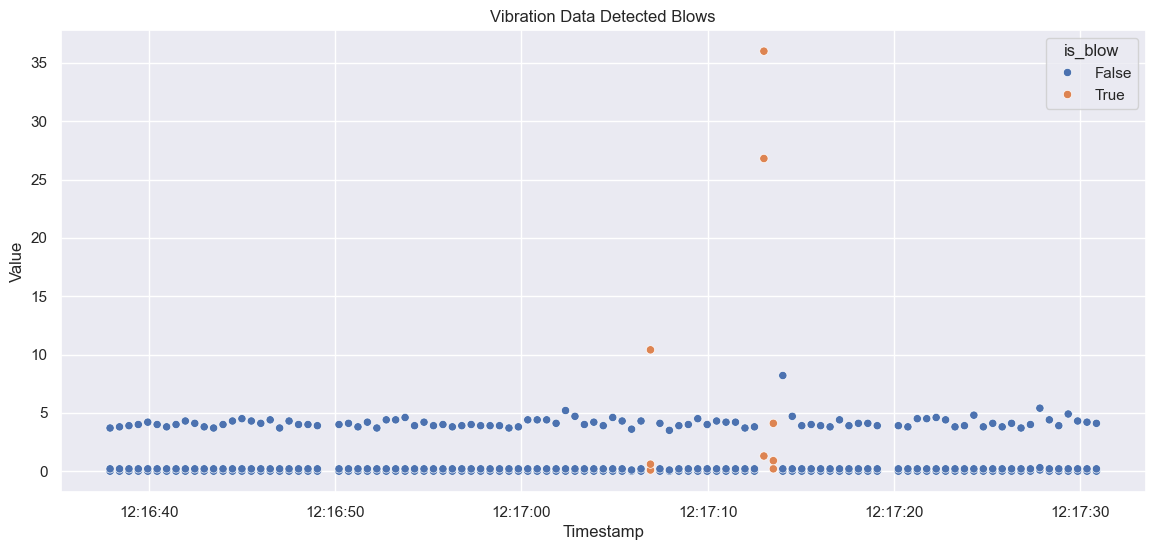

In [171]:
import seaborn as sns

vibration_data_long = pd.melt(vibration_data.reset_index(), id_vars=['timestamp', 'is_blow'], value_vars=vibration_data.select_dtypes("number").columns)

plt.figure(figsize=(14, 6))
sns.set_theme()
sns.scatterplot(data=vibration_data_long, x='timestamp', y='value', hue='is_blow')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Vibration Data Detected Blows')

plt.show()
